# Step 1: Towards coldmap
Test if gaussian blur will suffice

In [3]:
import cv2

def show_image(img):
    cv2.imshow('image', img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

avg_heatmap = cv2.imread('img/test/map1_path_thin.png')
g = 25
avg_heatmap = cv2.GaussianBlur(avg_heatmap, (g, g), 0)  # Kernel size must be odd

map1 = cv2.imread('img/test/map1.png')
path1 = cv2.imread('img/test/map1_path_thin.png')

combined = cv2.addWeighted(avg_heatmap, 1, path1, 1, 0)
combined2 = cv2.addWeighted(map1, 0.5, combined, 1, 0)


show_image(combined2)

In [4]:
thin_path = cv2.imread('img/test/map1_path_thin.png')

for g in range(3, 31, 2):
    gausBlur = cv2.GaussianBlur(thin_path, (g, g), 0)
    combined = cv2.addWeighted(gausBlur, 1, path1, 1, 0)
    combined2 = cv2.addWeighted(map1, 0.2, combined, 1, 0)
    
    cv2.imwrite(f'img/test/combined2_image_{g}.png', combined2)

_It does not_

# Step 2: Find distance of each pixel from the nearest white pixel

### Slow, non-parallelized

In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from scipy.spatial import distance

path = cv2.imread('img/cmap/line_path_small_curve.png', cv2.IMREAD_GRAYSCALE)

# Create a binary image where non-black pixels are 1 and black pixels are 0
_, binary = cv2.threshold(path, 1, 255, cv2.THRESH_BINARY)

# Compute the distance transform
#distance_map = cv2.distanceTransform(binary, cv2.DIST_L2, 5)

# Find the coordinates of the nearest non-black pixel for each pixel
nearest_coords = np.zeros((path.shape[0], path.shape[1], 2), dtype=int)
for i in range(path.shape[0]):
    for j in range(path.shape[1]):
        clear_output(wait=True)
        print(f"i={i}: {(i/400 * 100):.2f}%\nj={j}: {(j/400 * 100):.2f}%", end='\n')
        if binary[i, j] == 0:
            min_dist = float('inf')
            nearest_coord = (i, j)
            for x in range(path.shape[0]):
                for y in range(path.shape[1]):
                    if binary[x, y] != 0:
                        #dist = np.sqrt((i - x) ** 2 + (j - y) ** 2)
                        dist = distance.euclidean((i, j), (x, y))
                        if dist < min_dist:
                            min_dist = dist
                            nearest_coord = (x, y)
            nearest_coords[i, j] = nearest_coord
        else:
            nearest_coords[i, j] = (i, j)

print(nearest_coords)




i=39: 9.75%
j=90: 22.50%


KeyboardInterrupt: 

### Parallelized

In [6]:
import cv2
import numpy as np
from math import hypot  # for Euclidean distance
import multiprocessing as mp

def process_rows(start, end, binary):
    h, w = binary.shape
    result = np.zeros((end - start, w, 2), dtype=int)
    for i in range(start, end):
        for j in range(w):
            if binary[i, j] == 0:
                min_dist = float('inf')
                nearest_coord = (i, j)
                # Loop over every pixel to find the nearest non-black pixel
                for x in range(h):
                    for y in range(w):
                        if binary[x, y] != 0:
                            # Use hypot for a small speed improvement
                            d = hypot(i - x, j - y)
                            if d < min_dist:
                                min_dist = d
                                nearest_coord = (x, y)
                result[i - start, j] = nearest_coord
            else:
                result[i - start, j] = (i, j)
    return result

if __name__ == '__main__':
    # Load the image
    path = cv2.imread('img/cmap/line_path_small.png', cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(path, 1, 255, cv2.THRESH_BINARY)
    
    h, w = binary.shape
    num_processes = mp.cpu_count()  # or set to a fixed number
    chunk_size = h // num_processes

    # Prepare tasks for each process
    tasks = []
    for p in range(num_processes):
        start = p * chunk_size
        # Make sure the last chunk includes any remaining rows
        end = h if p == num_processes - 1 else (p + 1) * chunk_size
        tasks.append((start, end, binary))

    # Use a Pool to process rows in parallel
    with mp.Pool(num_processes) as pool:
        results = pool.starmap(process_rows, tasks)

    # Concatenate the results from each process
    nearest_coords = np.concatenate(results, axis=0)
    
    print("Nearest coordinates computed in parallel!")


Nearest coordinates computed in parallel!


### Make above into single(-ish) function
For convenience

In [7]:
import cv2
import numpy as np
from math import hypot  # for Euclidean distance
import multiprocessing as mp

def process_rows(start, end, binary):
    h, w = binary.shape
    result = np.zeros((end - start, w, 2), dtype=int)
    for i in range(start, end):
        for j in range(w):
            if binary[i, j] == 0:
                min_dist = float('inf')
                nearest_coord = (i, j)
                # Loop over every pixel to find the nearest non-black pixel
                for x in range(h):
                    for y in range(w):
                        if binary[x, y] != 0:
                            # Use hypot for a small speed improvement
                            d = hypot(i - x, j - y)
                            if d < min_dist:
                                min_dist = d
                                nearest_coord = (x, y)
                result[i - start, j] = nearest_coord
            else:
                result[i - start, j] = (i, j)
    return result

def get_nearest_coords(image_path: str):
    if not image_path:
        raise ValueError("Please provide a valid image path.")
    
    path = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    _, binary = cv2.threshold(path, 1, 255, cv2.THRESH_BINARY)
    
    h, w = binary.shape
    num_processes = mp.cpu_count()
    chunk_size = h // num_processes
    
    tasks = []
    for p in range(num_processes):
        start = p * chunk_size
        # Make sure the last chunk includes any remaining rows
        end = h if p == num_processes - 1 else (p + 1) * chunk_size
        tasks.append((start, end, binary))

    # Use a Pool to process rows in parallel
    with mp.Pool(num_processes) as pool:
        results = pool.starmap(process_rows, tasks)

    # Concatenate the results from each process
    nearest_coords = np.concatenate(results, axis=0)
    
    return nearest_coords
    


# Example usage:
if __name__ == '__main__':
    image_path = 'img/cmap/line_path_small_curve.png'
    coords = get_nearest_coords(image_path)
    print("Nearest coordinates array shape:", coords.shape)


Nearest coordinates array shape: (100, 100, 2)


# Step 3: Colour each pixel based on distance

In [8]:
rows = coords.shape[0]
cols = coords.shape[1]

heatmap = np.zeros((rows, cols), dtype=np.uint8) # uint8 = 0 to 255
for i in range(0, rows):
    for j in range(0, cols):
        heatmap[i, j] = int(hypot(i - coords[i, j][0], j - coords[i, j][1]))
        

# Step 4: Combine to make magic

In [9]:
def generate_coldmap(image_path: str):
    if not image_path:
        raise ValueError("Please provide a valid image path.")
    
    coords = get_nearest_coords(image_path)
    
    rows = coords.shape[0]
    cols = coords.shape[1]
    
    coldmap = np.zeros((rows, cols), dtype=np.uint8)
    for i in range(0, rows):
        for j in range(0, cols):
            coldmap[i, j] = int(255 * hypot(i - coords[i, j][0], j - coords[i, j][1]) / np.max(coords))
            
    return coldmap 
    

In [ ]:
cmap = generate_coldmap('img/cmap/map1_path_thin.png') # 8 minutes
plt.imshow(cmap, cmap='inferno')

# Step 5: Change gradient to be more rapid the further away from white
Also change functions around.

In [ ]:
import numpy as np
from math import hypot

def coords_to_coldmap(coords, threshold: float = 10, exponent: float = 0.75, normalize: int = 255):
    rows, cols = coords.shape[0], coords.shape[1]
    
    # Compute the Euclidean distances.
    distances = np.zeros((rows, cols), dtype=np.float32)
    for i in range(rows):
        for j in range(cols):
            distances[i, j] = hypot(i - coords[i, j][0], j - coords[i, j][1])
    
    # Initialize the transformed array with the original distances.
    transformed = distances.copy()
    
    # Create a mask for pixels with distance > threshold.
    mask = distances > threshold
    # Only update those pixels: apply the transformation for distances above the threshold.
    transformed[mask] = threshold + (distances[mask] - threshold) ** exponent
    
    # Normalize the transformed values to the 0–normalize range.
    transformed_normalized = normalize * (transformed - transformed.min()) / (transformed.max() - transformed.min())
    
    return_type = np.uint8 if normalize == 255 else np.float32
    
    return transformed_normalized.astype(return_type)

In [11]:
coords = get_nearest_coords('img/cmap/line_path_small_curve.png')


In [ ]:
import matplotlib.pyplot as plt


cmap = coords_to_coldmap(coords, 5, 0.75)
plt.imshow(cmap, cmap='inferno')
plt.colorbar()

Threshold=10, Exponent=0.5 done!
Threshold=20, Exponent=0.5 done!
Threshold=40, Exponent=0.5 done!
Threshold=70, Exponent=0.5 done!
Threshold=100, Exponent=0.5 done!
Threshold=10, Exponent=0.75 done!
Threshold=20, Exponent=0.75 done!
Threshold=40, Exponent=0.75 done!
Threshold=70, Exponent=0.75 done!
Threshold=100, Exponent=0.75 done!
Threshold=10, Exponent=1.25 done!
Threshold=20, Exponent=1.25 done!
Threshold=40, Exponent=1.25 done!
Threshold=70, Exponent=1.25 done!
Threshold=100, Exponent=1.25 done!


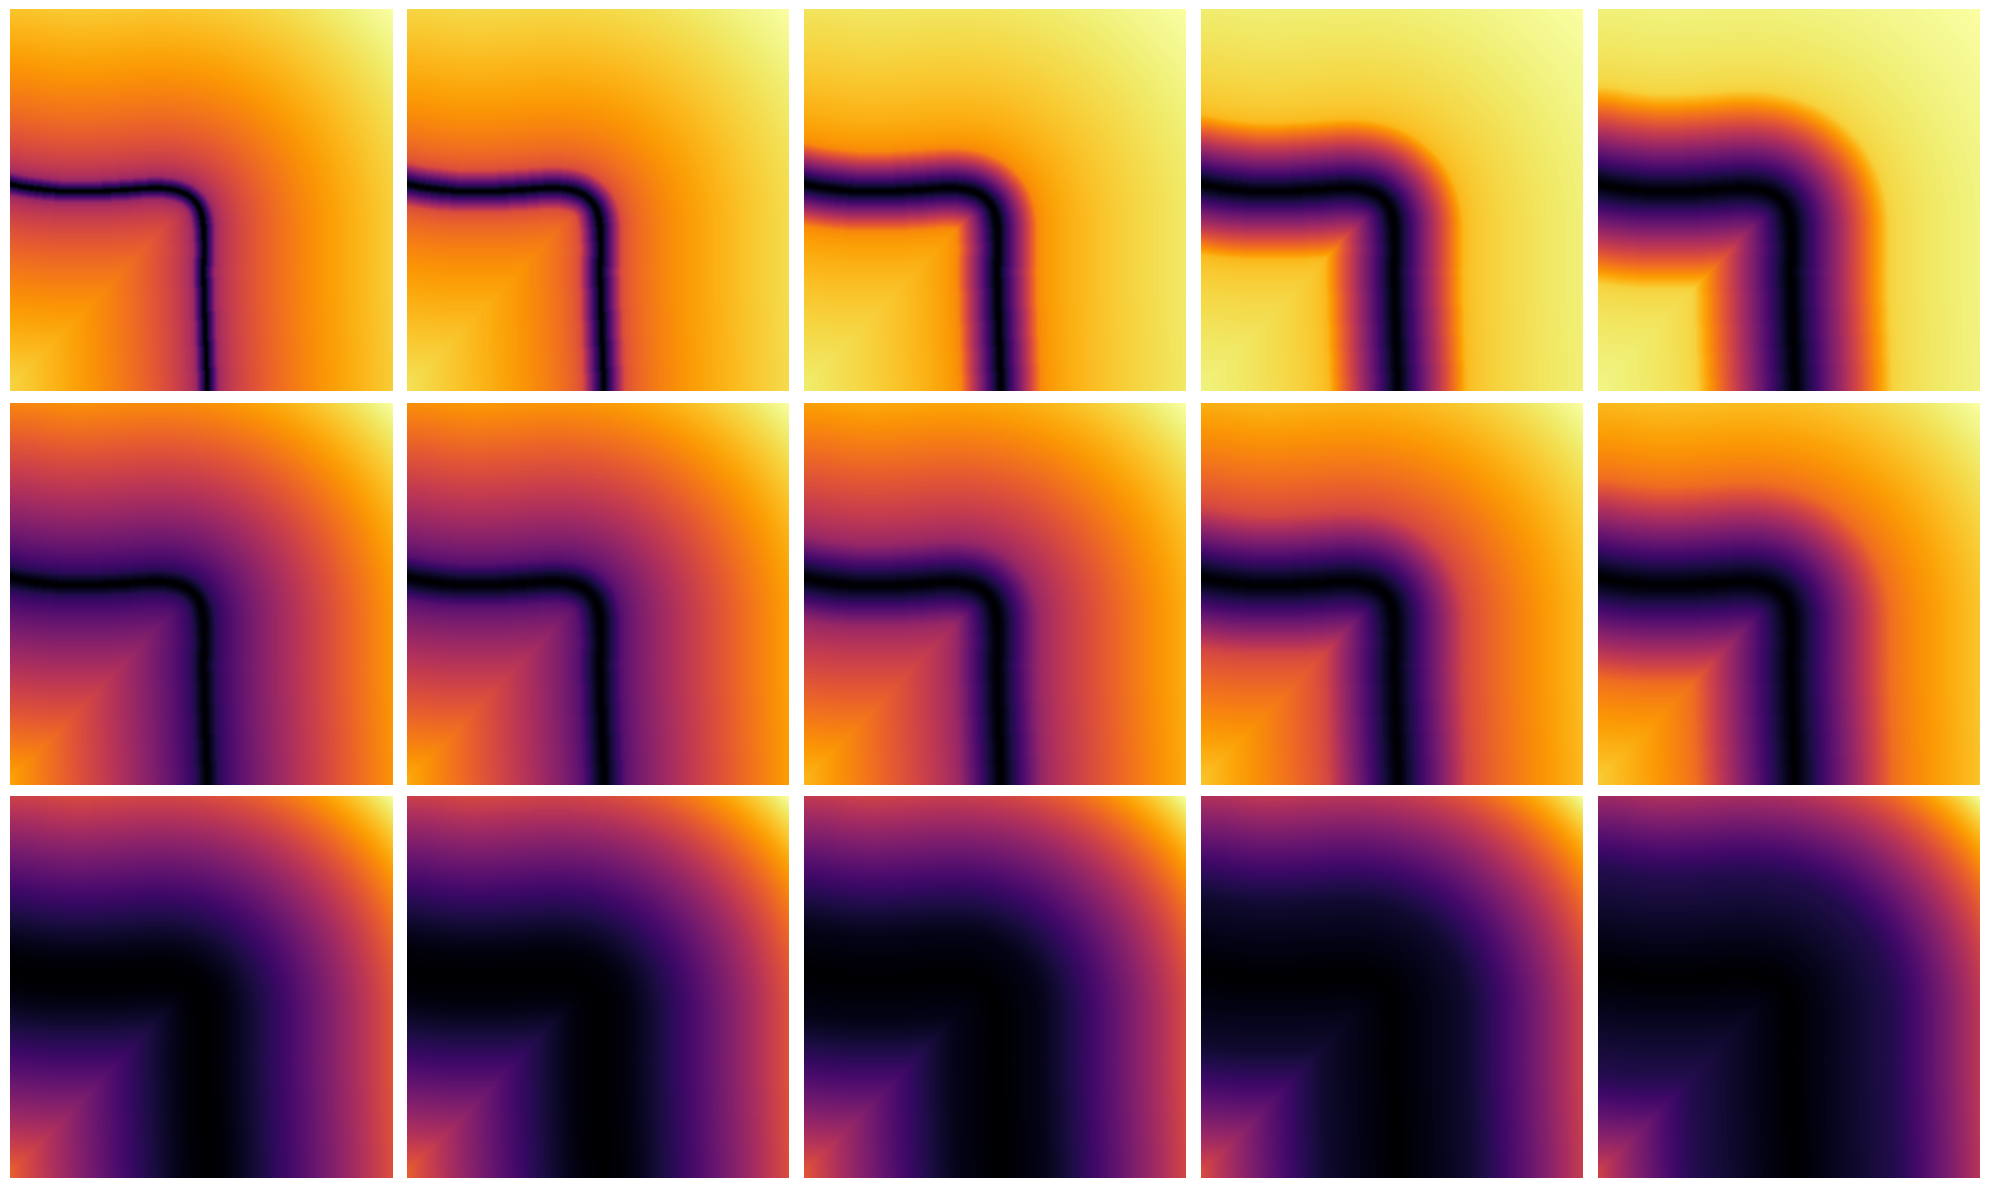

In [87]:
thresholds = [10, 20, 40, 70, 100]
exponents = [0.5, 0.75, 1.25]

fig, axs = plt.subplots(len(exponents), len(thresholds), figsize=(20, 12))

#coords2 = get_nearest_coords('img/cmap/line_path_small_curve.png')

for i, e in enumerate(exponents):
    for j, t in enumerate(thresholds):
        cmap = coords_to_coldmap(coords, t, e)
        axs[i, j].imshow(cmap, cmap='inferno')
        #axs[i, j].set_title(f"Threshold={t}, Exponent={e}", fontsize=18)
        axs[i, j].axis('off')
        print(f"Threshold={t}, Exponent={e} done!")

#fig.colorbar(axs[0, -1].get_images()[0], ax=axs, orientation='vertical', fraction=1/25)
plt.tight_layout()
plt.show()

In [88]:
# save fig with alpha background
fig.savefig('img/cmap/coldmaps_comp_notitles.png', transparent=True)

# Step 6: Loss function testing

In [18]:
import torch

image_path = 'img/cmap/line_path_small_curve.png'
image_test = 'img/cmap/line_path_small.png'

In [19]:
coords = get_nearest_coords(image_path)
cmap = coords_to_coldmap(coords, 20, 0.5)
type(cmap)

numpy.ndarray

In [20]:
cmap = torch.from_numpy(cmap)
cmap_f = torch.flatten(cmap)
cmap_f.shape

torch.Size([10000])

In [21]:
path = cv2.imread(image_test, cv2.IMREAD_GRAYSCALE)
path_np = np.array(path)
path_t = torch.from_numpy(path_np)
path_f = torch.flatten(path_t)
path_f.shape

torch.Size([10000])

In [22]:
res = torch.dot(cmap_f, path_f)
res


tensor(186, dtype=torch.uint8)

In [23]:
def compare(to_cmap: str, comp_path: str, threshold: float = 20, exponent: float = 0.5):
    if not to_cmap or not comp_path:
        raise ValueError("Please provide valid image paths.")
    
    coords = get_nearest_coords(to_cmap)
    cmap = coords_to_coldmap(coords, threshold, exponent)
    cmap = torch.from_numpy(cmap)
    cmap_f = torch.flatten(cmap)
    
    path = cv2.imread(comp_path, cv2.IMREAD_GRAYSCALE)
    path_np = np.array(path)
    path_t = torch.from_numpy(path_np)
    path_f = torch.flatten(path_t)
    
    res = torch.dot(cmap_f, path_f)
    
    return res
    

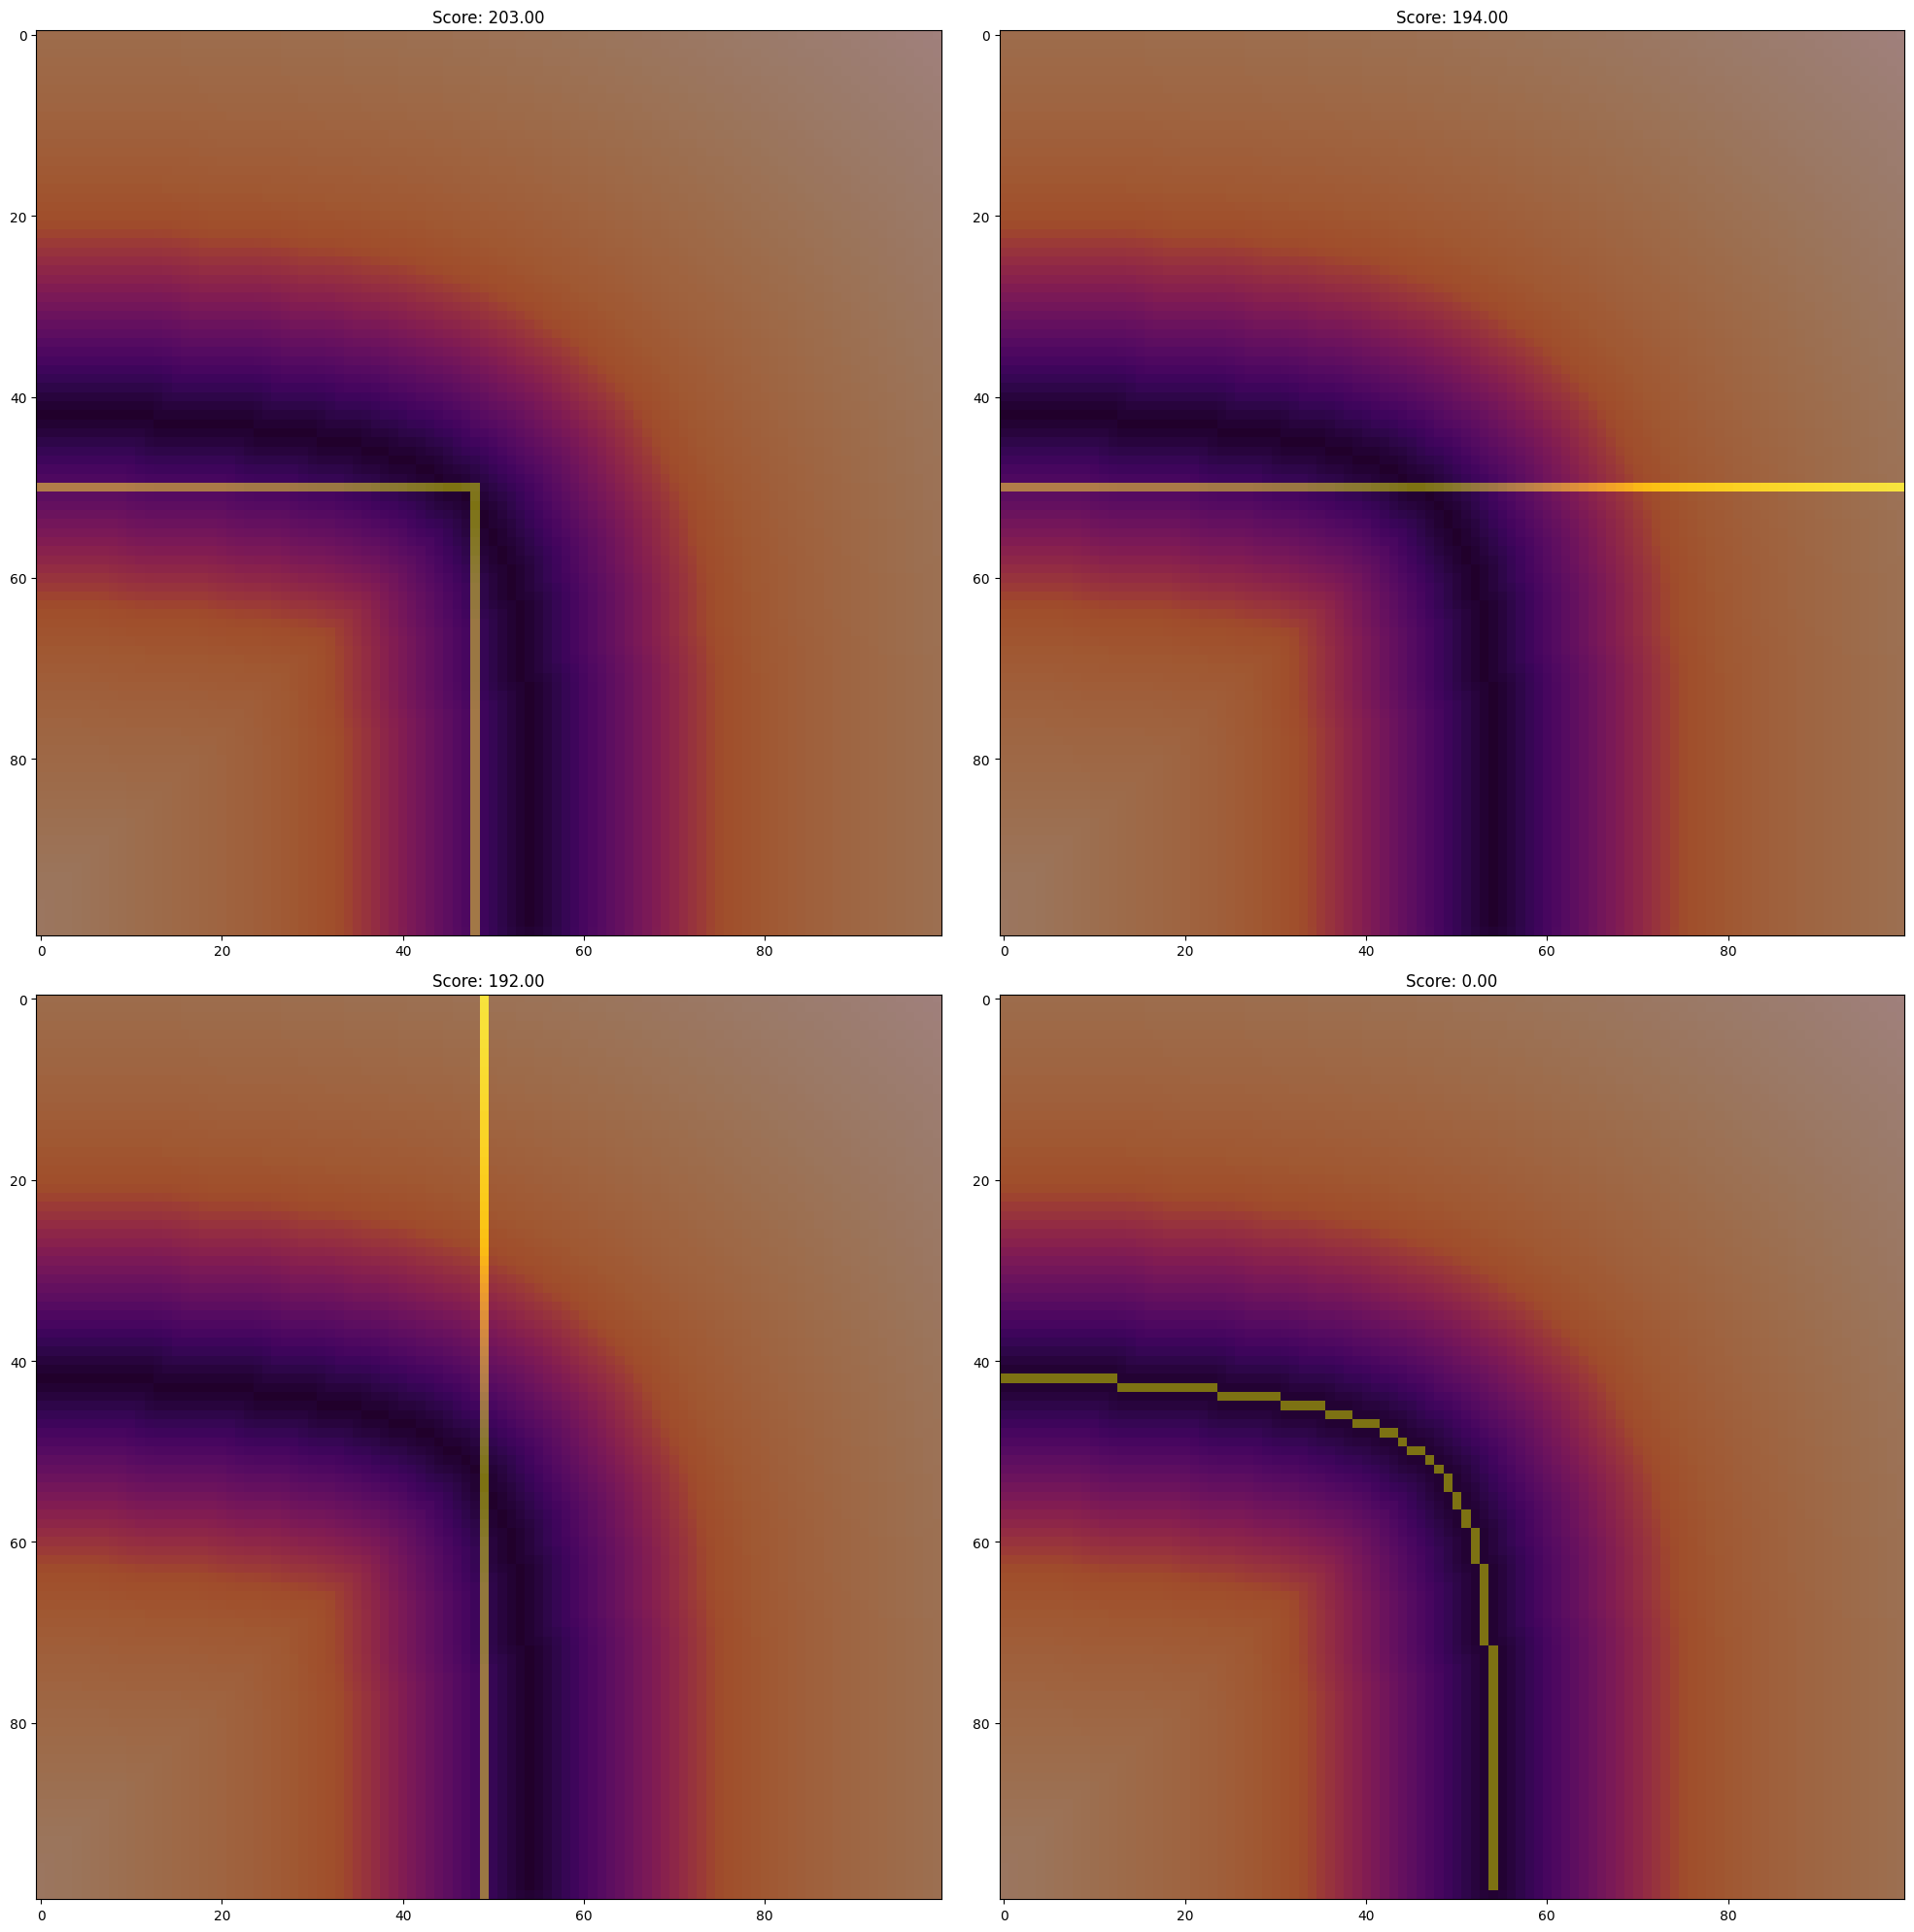

In [31]:
to_cmap = "img/cmap/line_path_small_curve.png"
comp_paths = [f"img/cmap/comp{i}.png" for i in range(1, 4)]
comp_paths.append("img/cmap/line_path_small_curve.png")

c = cmap
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

axs[0][0].imshow(c, cmap='inferno')
path = cv2.imread(comp_paths[0], cv2.IMREAD_GRAYSCALE)
path_np = np.array(path)
p = np.where(path_np == 255, 1, 0)
axs[0][0].imshow(p, alpha=0.5)
res = compare(to_cmap, comp_paths[0])
axs[0][0].set_title(f"Score: {res:.2f}")

axs[0][1].imshow(c, cmap='inferno')
path = cv2.imread(comp_paths[1], cv2.IMREAD_GRAYSCALE)
path_np = np.array(path)
p = np.where(path_np == 255, 1, 0)
axs[0][1].imshow(p, alpha=0.5)
res = compare(to_cmap, comp_paths[1])
axs[0][1].set_title(f"Score: {res:.2f}")


axs[1][0].imshow(c, cmap='inferno')
path = cv2.imread(comp_paths[2], cv2.IMREAD_GRAYSCALE)
path_np = np.array(path)
p = np.where(path_np == 255, 1, 0)
axs[1][0].imshow(p, alpha=0.5)
res = compare(to_cmap, comp_paths[2])
axs[1][0].set_title(f"Score: {res:.2f}")

axs[1][1].imshow(c, cmap='inferno')
path = cv2.imread(comp_paths[3], cv2.IMREAD_GRAYSCALE)
path_np = np.array(path)
p = np.where(path_np == 255, 1, 0)
axs[1][1].imshow(p, alpha=0.5)
res = compare(to_cmap, comp_paths[3])
axs[1][1].set_title(f"Score: {res:.2f}")

fig.tight_layout()


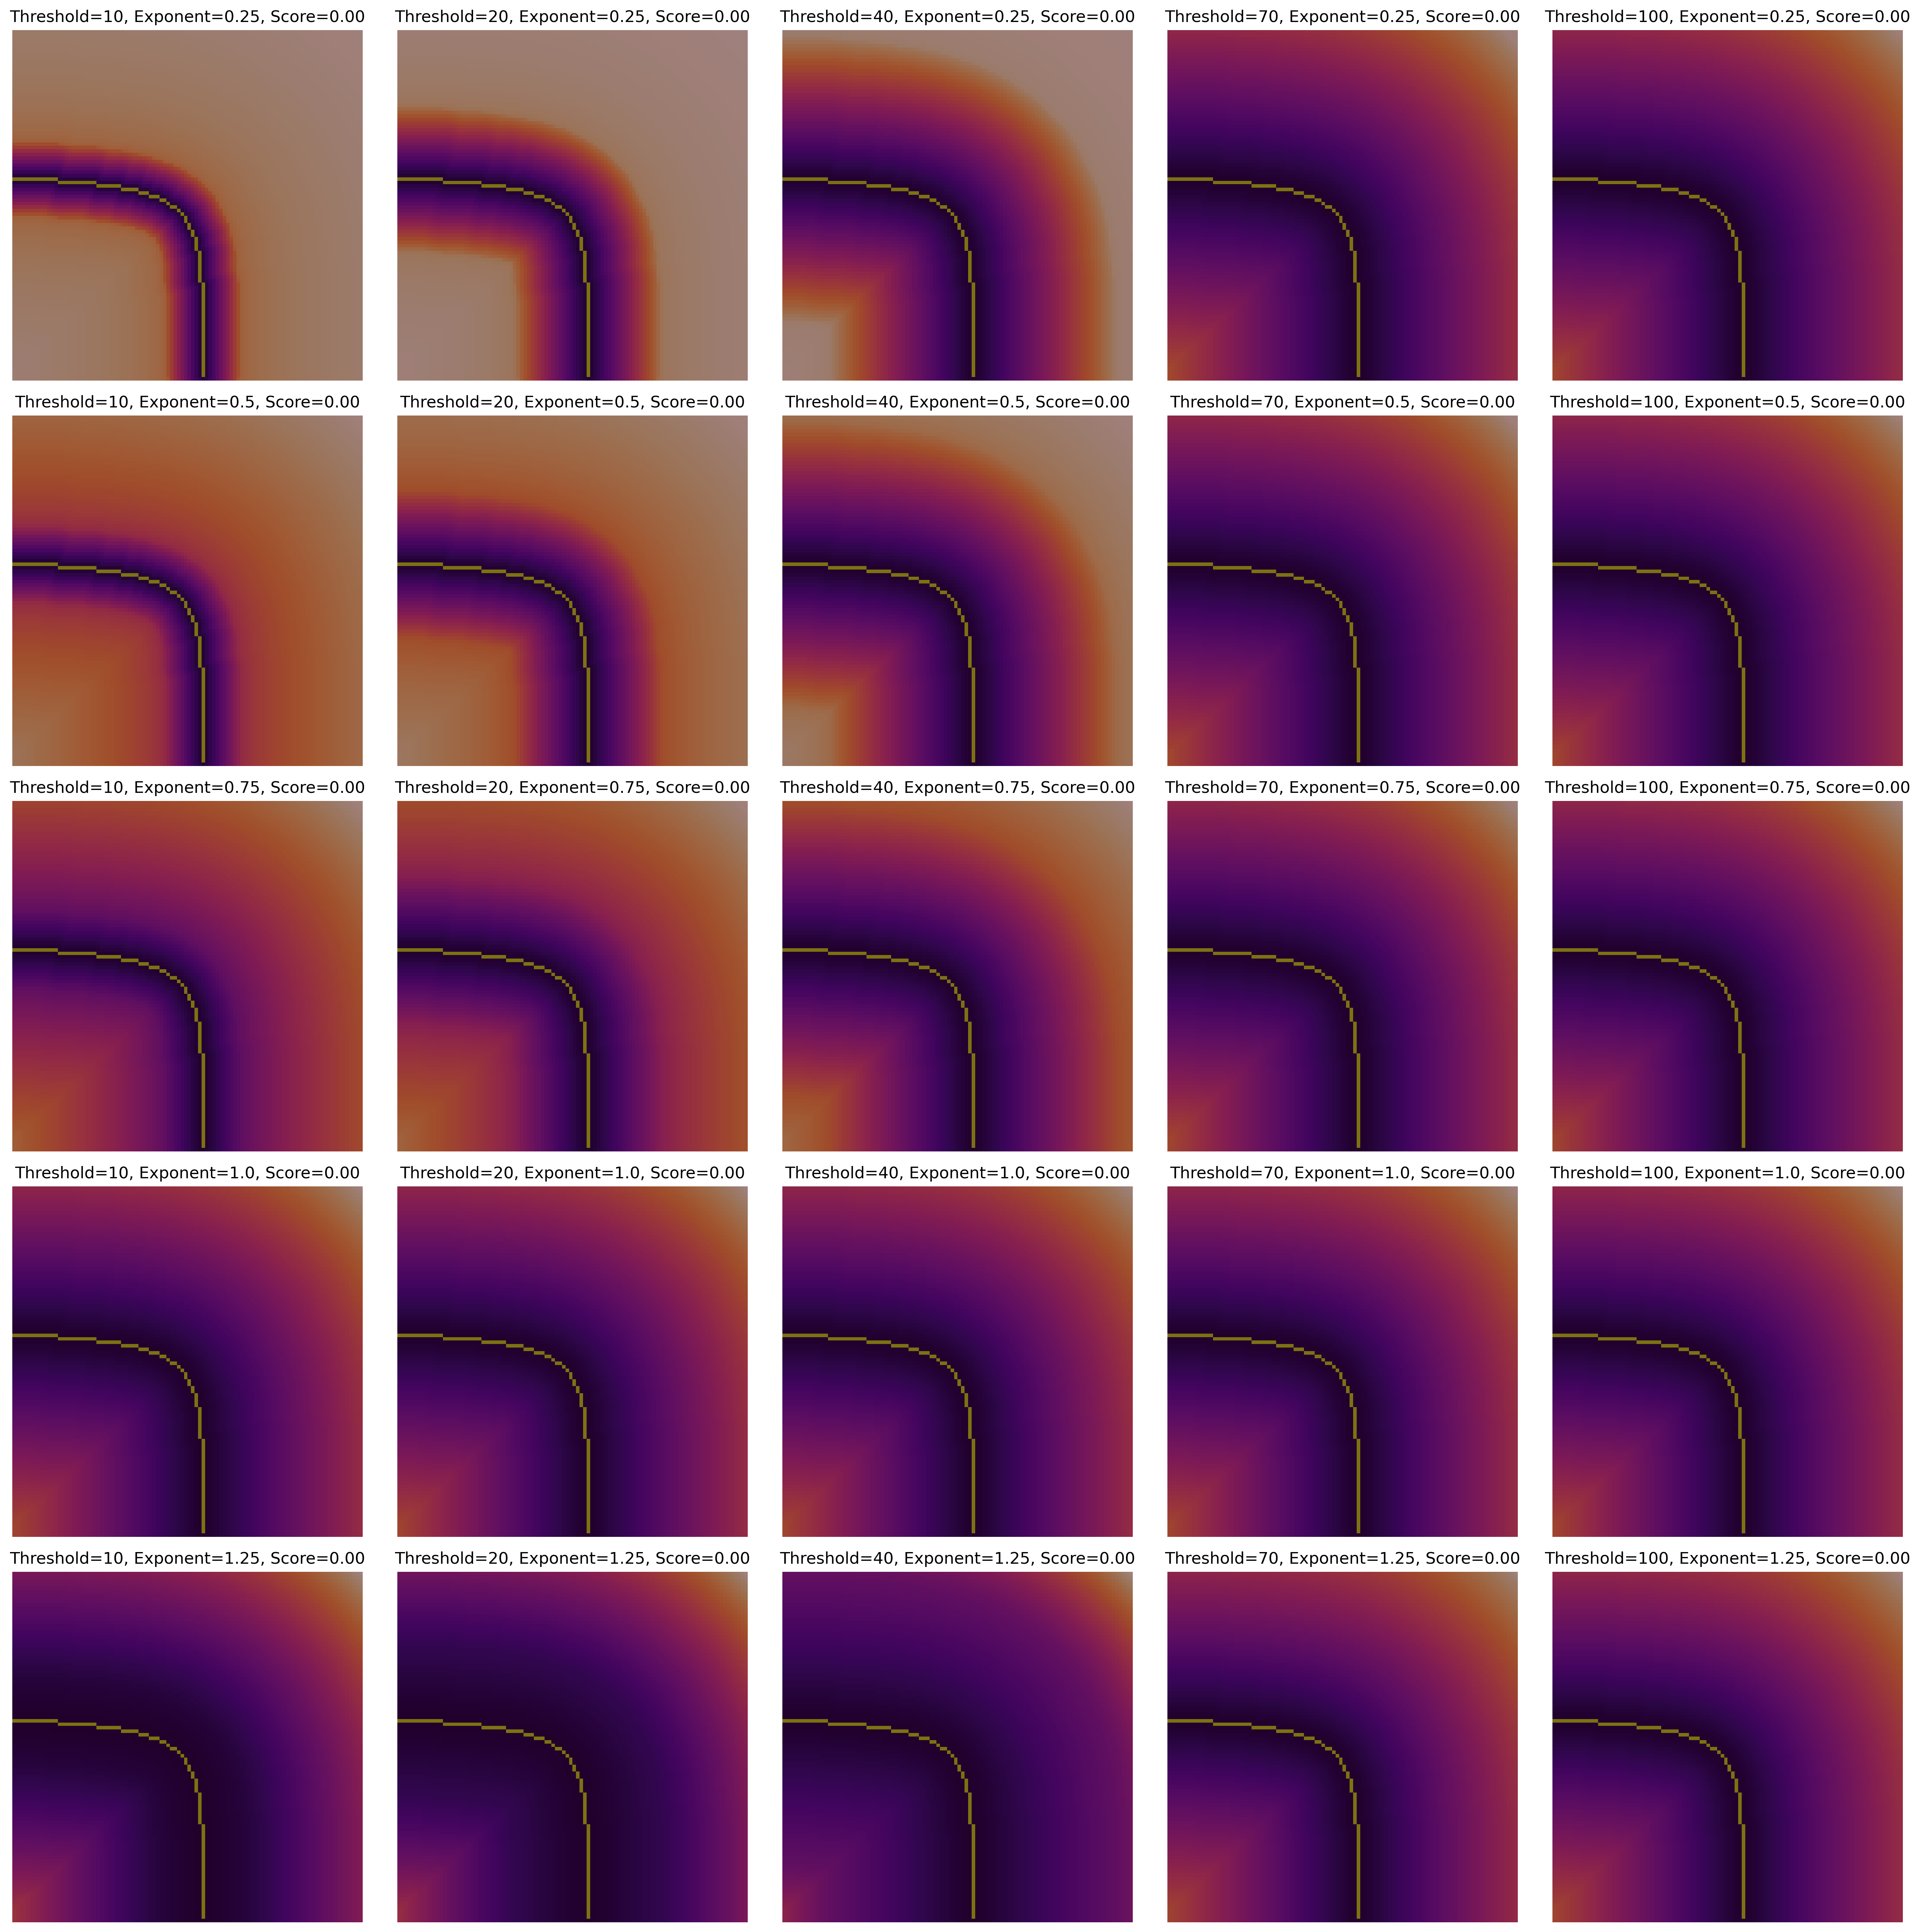

In [93]:
thresholds = [10, 20, 40, 70, 100]
exponents = [0.25, 0.5, 0.75, 1.0, 1.25]

fig, axs = plt.subplots(len(exponents), len(thresholds), figsize=(20, 20), dpi=300)

path = cv2.imread('img/cmap/line_path_small_curve.png', cv2.IMREAD_GRAYSCALE)
path_np = np.array(path)
p = np.where(path_np == 255, 1, 0)

coords = get_nearest_coords('img/cmap/line_path_small_curve.png')

for i, e in enumerate(exponents):
    for j, t in enumerate(thresholds):
        cmap = coords_to_coldmap(coords, t, e)
        axs[i, j].imshow(cmap, cmap='inferno')
        axs[i, j].imshow(p, alpha=0.5)
        score = compare('img/cmap/line_path_small_curve.png', 'img/cmap/line_path_small_curve.png', t, e)
        axs[i, j].set_title(f"Threshold={t}, Exponent={e}, Score={score:.2f}")
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

# Step 7: Create dataset folder structure

In [33]:
import matplotlib.pyplot as plt

# Base picture (intersection)
base_intersection = "train/intersection1/map.png"
base_intersection = cv2.imread(base_intersection, cv2.IMREAD_COLOR_BGR)

# Ground truth path
gt_path = "train/intersection1/map_path_thin.png"
gt_path_i = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

# Cold map
threshold = 20
exponent = 0.5
coords = get_nearest_coords(gt_path)
cmap = coords_to_coldmap(coords, threshold, exponent)

# Save the cold map
cv2.imwrite("train/intersection1/cold_map.png", cmap)

True

# Step 8: Optimize algorithm further

In [ ]:
from dataset_lib import *

In [17]:
input_path = "img/cmap/map1_path_thin.png"
output_path = "img/cmap/map1_path_thin_tmp2.png"
coords = get_nearest_coords(input_path, process_rows2)
coldmap = coords_to_coldmap(coords, threshold=20, exponent=0.5)
save_coldmap(coldmap, output_path)

Processing img/cmap/map1_path_thin.png


Process 32832 is processing rows 0 to 50Process 32835 is processing rows 150 to 200
Process 32833 is processing rows 50 to 100

  0%|          | 0/50 [00:00<?, ?it/s]


Process 32838 is processing rows 300 to 350


  0%|          | 0/50 [00:00<?, ?it/s]

Process 32837 is processing rows 250 to 300
Process 32836 is processing rows 200 to 250

  0%|          | 0/50 [00:00<?, ?it/s]

Process 32834 is processing rows 100 to 150
Process 32839 is processing rows 350 to 400


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:02<00:00, 19.28it/s]


Creating coldmap...
Coldmap created.
Coldmap saved to img/cmap/map1_path_thin_tmp2.png
